In [1]:
%load_ext autoreload
%autoreload 2
import os
CACHE_DIR = f"/scratch/{os.getenv('USER')}/huggingface_cache"

### Parameter Estimation using Bayesian Network

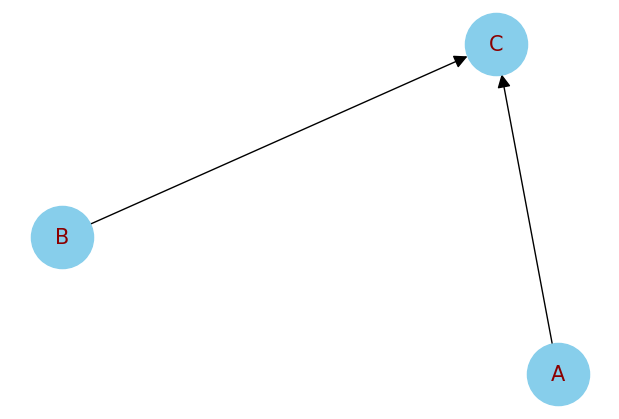

In [30]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
import networkx as nx
import matplotlib.pyplot as plt



# define BN
network = [('A', 'C'), ('B', 'C')]
model = BayesianNetwork(network)
G = nx.DiGraph(network)

plt.figure(figsize=(6, 4))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=2000, font_size=15, font_color='darkred', arrowstyle='-|>', arrowsize=20)
plt.show()

In [31]:
# Data for parameter estimation
data = pd.DataFrame(data={'A': [0, 0, 1], 'B': [0, 1, 0], 'C': [1, 1, 0]})
data

,A,B,C
0,0,0,1
1,0,1,1
2,1,0,0


##### MLE

In [32]:
estimator = MaximumLikelihoodEstimator(model, data)
cpd_A = estimator.estimate_cpd('A')
print(cpd_A)
cpd_C = estimator.estimate_cpd('C')
print(cpd_C)

+------+----------+
| A(0) | 0.666667 |
+------+----------+
| A(1) | 0.333333 |
+------+----------+
+------+------+------+------+------+
| A    | A(0) | A(0) | A(1) | A(1) |
+------+------+------+------+------+
| B    | B(0) | B(1) | B(0) | B(1) |
+------+------+------+------+------+
| C(0) | 0.0  | 0.0  | 1.0  | 0.5  |
+------+------+------+------+------+
| C(1) | 1.0  | 1.0  | 0.0  | 0.5  |
+------+------+------+------+------+


##### Bayesian Estimator

In [33]:
estimator = BayesianEstimator(model, data)
cpd_C = estimator.estimate_cpd('C', prior_type="dirichlet",
                               pseudo_counts=[[1, 1, 1, 1],
                                              [2, 2, 2, 2]])
print(cpd_C)

+------+------+------+------+--------------------+
| A    | A(0) | A(0) | A(1) | A(1)               |
+------+------+------+------+--------------------+
| B    | B(0) | B(1) | B(0) | B(1)               |
+------+------+------+------+--------------------+
| C(0) | 0.25 | 0.25 | 0.5  | 0.3333333333333333 |
+------+------+------+------+--------------------+
| C(1) | 0.75 | 0.75 | 0.5  | 0.6666666666666666 |
+------+------+------+------+--------------------+


In [ ]:
estimator = ExpectationMaximization(model, data)